# 0. Notebook prep

In [10]:
import numpy as np
from matplotlib import pyplot as plt
import os 
ae_ae_loss = np.load("visualization/ae_ae_loss.npy")
ae_ae_loss = np.mean(ae_ae_loss.reshape(1000, 100), axis=-1)
ae_rnn_loss = np.load("visualization/ae_rnn_loss.npy")
ae_rnn_loss = np.mean(ae_rnn_loss.reshape(1000, 100), axis=-1)
bow_ae_loss = np.load("visualization/bow_ae_loss.npy")
bow_ae_loss = np.mean(bow_ae_loss.reshape(1000, 100), axis=-1)
bow_rnn_loss = np.load("visualization/bow_rnn_loss.npy")
bow_rnn_loss = np.mean(bow_rnn_loss.reshape(1000, 100), axis=-1)
rnn_loss = np.load("visualization/rnn_loss.npy")
rnn_loss = np.mean(rnn_loss.reshape(1000, 100), axis=-1)

# 1. Recurrent Neural Language Model 

Given the one-hot embeddings $\{\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T}\}$ of a specific sentence, the RNNLM can assign the probability to the sentence as follow
\begin{equation}
	\boldsymbol{h}_{t} = f(\boldsymbol{E}_{in}\boldsymbol{x}_{t},  \boldsymbol{h}_{t-1})
\end{equation}
\begin{equation}
	\boldsymbol{o}_{t} = \boldsymbol{W}_{o}\boldsymbol{h}_{t} + \boldsymbol{b}_{o}
\end{equation}
\begin{equation}
	y_{t} = \frac{\exp(\boldsymbol{o}_{t}^{T}\boldsymbol{E}_{out}\boldsymbol{x}_{t+1})}{\sum_{\boldsymbol{x}_{k} \in \boldsymbol{V}}\exp(\boldsymbol{o}_{t}^{T}\boldsymbol{E}_{out}\boldsymbol{x}_{k})}
\end{equation}
where the function $f(\cdot)$ is a single step RNN operation and $\boldsymbol{V}$ is the collection of one-hot vectors for full vocabulary. 
Then probability given by the recurrent network to the input sequence $\{\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T}\}$ is 
\begin{equation}
	p(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T}) = \prod_{t=1}^{T} p(\boldsymbol{x}_{t+1}|y_{t})
\end{equation}
and the sequence loss $\mathcal{L}_{rnn}$ used to train the network is the negative logarithm of $p(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T})$
\begin{equation}
	\mathcal{L}^{rnn} = -\sum_{t=1}^{T}\log p(\boldsymbol{x}_{t+1}|y_{t})
\end{equation}

# 2. Recurrent Neural Language Model with Autoencoder

The RNNLM discussed above can combine with an autoencoder by modified the equation (2) as 
\begin{equation}
\boldsymbol{o}_{t} = \boldsymbol{W}_{o}\boldsymbol{h}_{t} +\boldsymbol{W}_{z}\boldsymbol{z} +  \boldsymbol{b}_{o}
\end{equation}
where $\boldsymbol{z}$ is the dense representation of $\{\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T}\}$ encoded by autoencoder as follow
\begin{equation}
\boldsymbol{g}_{in} = \text{Relu}(\boldsymbol{W}_{in}\begin{bmatrix}
\boldsymbol{E}_{in}\boldsymbol{x}_{1}\\
.\\
.\\
.\\
\boldsymbol{E}_{in}\boldsymbol{x}_{T}\\
\end{bmatrix} + \boldsymbol{b}_{in})
\end{equation}
\begin{equation}
	\boldsymbol{z} = \text{Relu}(\boldsymbol{W}_{g}\boldsymbol{g}_{in}+ \boldsymbol{b}_{g})
\end{equation}
\begin{equation}
	\boldsymbol{g}_{out} = \text{Relu}(\boldsymbol{W}_{out}\boldsymbol{z} + \boldsymbol{b}_{out})
\end{equation}
The output of autoencode is 
\begin{equation}
	y_{t}^{ae} = \frac{\exp(\boldsymbol{g}_{out}^{T}\boldsymbol{E}_{out}\boldsymbol{x}_{t})}{\sum_{\boldsymbol{x}_{k}\in \boldsymbol{V}}\exp(\boldsymbol{g}_{out}^{T}\boldsymbol{E}_{out}\boldsymbol{x}_{k})}
\end{equation}
The probability given by the autoencoder to the input sequence $\{\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T}\}$ is 
\begin{equation}
	p(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, ... , \boldsymbol{x}_{T}) = \prod_{t=1}^{T} p(\boldsymbol{x}_{t}|y_{t}^{ae})
\end{equation}
and the loss $\mathcal{L}^{ae}$ defined on the autoencoder is 
\begin{equation}
	\mathcal{L}^{ae} = -\sum_{t=1}^{T}\log p(\boldsymbol{x}_{t}|y_{t}^{ae})
\end{equation}
then the total loss of this joint model is 
\begin{equation}
	\mathcal{L} = (1.0 - \alpha)\mathcal{L}^{ae} + \alpha\mathcal{L}^{rnn}
\end{equation}
where $\alpha$ is a hyper-parameter.

# 3. Experiment Settings 
We selected 300k sentences of 20 words length from One Billion Sentences Evaluation dataset and keep 1k of them as testing examples. 
And we keep 40,000 most frequent words in our vocabulary and replace other words with ``$<\text{unk}>$'' token. 
When building our model we use gated recurrent unit (GRU) as the cell for our recurrent networks.
We train our model for 10 epoches on the selected sentences. 
Note that the AE + RNNLM model is tried three times with $\alpha = \{0.1, 0.5, 0.9\}$.
The table below gives the detail about the model's dimensionality.


|        |        Vocabulary Size    | Embedding dimension | Hidden (RNN) | Hidden (AE) | 
| -------| :-------------------------:| :------------------:|:------------:| :-----------:| 
| RNN      | 40004 |  256| 512 | -| 
| AE + RNN      | 40004     |   256 | 512 | 512| 
| BW + RNN      | 40004     |   256 | 512 | 512| 

# 4. Comparison 
## 4.1 Loss
The figures below show the training loss between BW + RNN and AE + RNNLM

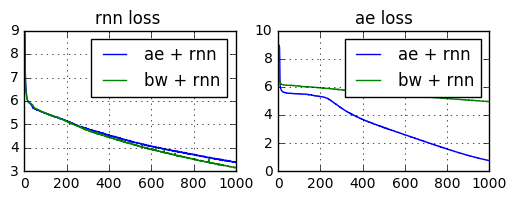

In [12]:
plt.figure(1)

# linear
plt.subplot(221)
plt.plot(ae_rnn_loss, label="ae + rnn")
plt.plot(bow_rnn_loss, label="bw + rnn")
plt.yscale('linear')
plt.title('rnn loss ')
plt.legend()
plt.grid(True)


# log
plt.subplot(222)
plt.plot(ae_ae_loss, label="ae + rnn")
plt.plot(bow_ae_loss, label="bw + rnn")
plt.yscale('linear')
plt.title('ae loss')
plt.legend()
plt.grid(True)

plt.show()


## 4.2 Sample From RNN
The setences below are samples drawn from standard RNNLM

In [14]:
with open("visualization/rnn_sample.txt", "r") as samples:
    for line in samples:
        print(line)

1th RNN Sample :  a little be already guy on the current pattern , entering london , laugh .

2th RNN Sample :  uk major winner within 1999 to the agency six crash in € district seas .

3th RNN Sample :  do i buy the system to be having an competitive enemy wins the system .

4th RNN Sample :  hollywood were injured to the content at paris 's african major killing metal windows .

5th RNN Sample :  roman will betting since loans to flood more present legendary and each month support .

6th RNN Sample :  jail , from many areas now were set away to their stomach handling dame .

7th RNN Sample :  china officials and serena alike were gaining year ; the crowded hotel and faces .

8th RNN Sample :  murphy has announced how two times indicator are expected to secure down discomfort race .

9th RNN Sample :  it won some respected may the new government council , british news here said .

10th RNN Sample :  i saw it keys out of a long objective and department ! has arrived .



## 4.3 Sample From AE+RNN and BW+RNN

The sentences below are max-likelihood sentences find based on 100 samples 

In [23]:
prefix = "multi"
file_type = ".txt"
orign = prefix + file_type
ae_sample = "ae_" + prefix + file_type
bw_sample = "bow_" + prefix + file_type
with open("visualization/" + orign, "r") as doc1, open("visualization/" + ae_sample, "r") as doc2, open("visualization/" + bw_sample, "r") as doc3:
    
    for line in doc1:
        print("origin : " + line)
        print("  ae   : " + doc2.readline())
        print("  bw   : " + doc3.readline())

origin : Elsewhere , two schools have collapsed , each trapping nearly 1,000 students and staff .

  ae   :  the explosives was confirmed high-profile against a 1,000 <unk> , karzai , <unk> said .

  bw   :  research <unk> <unk> , federal , however the white which trade , google its .

origin : Hooh Why , the morning line favorite , was scratched long before the start .

  ae   :  the event was released other than , <unk> , however , according the <unk> said

  bw   :  two , sweet schools those province older have have <unk> <unk> , half two .

origin : The public defender 's office , which is representing Pena , declined comment .

  ae   :  the analysts were also fell , <unk> , mr <unk> , <unk> during <unk> .

  bw   :  other owns , spain , boris philadelphia for other <unk> have payments every years .

origin : The Japanese were sweeping southwards , Singapore had fallen , Darwin had been bombed .

  ae   :  the result of georgia 600,000 , was billions completed by the home <unk> fo

# 5. Next steps

To be discussed 